<a href="https://colab.research.google.com/github/hyeonji826/AI/blob/gen-vision/%EC%9D%98%EC%95%BD%ED%92%88_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%env CUDA_LAUNCH_BLOCKING=1
%env FLAGS_call_stack_level=2

# cuDNN 경로 완전히 우회 (속도 조금↓, 안정성↑)
%env FLAGS_use_cudnn=False
%env FLAGS_conv2d_disable_cudnn=True
%env FLAGS_cudnn_exhaustive_search=False
%env FLAGS_cudnn_deterministic=True

# 메모리/커널 안정화
%env FLAGS_use_stream_safe_cuda_allocator=true
%env FLAGS_allocator_strategy=naive_best_fit
%env FLAGS_check_kernel_launch=1
%env FLAGS_enable_gpu_memory_usage_log_mb=true

env: CUDA_LAUNCH_BLOCKING=1
env: FLAGS_call_stack_level=2
env: FLAGS_use_cudnn=False
env: FLAGS_conv2d_disable_cudnn=True
env: FLAGS_cudnn_exhaustive_search=False
env: FLAGS_cudnn_deterministic=True
env: FLAGS_use_stream_safe_cuda_allocator=true
env: FLAGS_allocator_strategy=naive_best_fit
env: FLAGS_check_kernel_launch=1
env: FLAGS_enable_gpu_memory_usage_log_mb=true


In [3]:
import os
import zipfile
import shutil
import random
import cv2
import json
import matplotlib.pyplot as plt
import csv
import paddle
import subprocess, shlex, sys
import json, re, numpy as np
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from rapidfuzz.distance import Levenshtein
from math import atan2, degrees

### 데이터 준비

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 초기화 후 CP949로 해제
!rm -rf /content/data && mkdir -p /content/data
!unzip -qq -O CP949 "/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/생성형 AI/data/medicine.zip" -d /content/data

In [6]:
%pip install -q --no-cache-dir "pandas<2.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 252.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.
xarray 2025.7.1 requires pandas>=2.2, but you have pandas 2.1.4 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.


In [7]:
# === A. Manifest 기반 분할 + copy materialize (jpg/json만) ===
import pandas as pd


random.seed(2025)

# 원본 경로(고정)
IMG_SRC = Path("/content/data/원천데이터/TS1/result/medicine/images")
ANN_SRC = Path("/content/data/라벨링데이터/TL1/result/medicine/annotations")

# 분할 결과물 경로(원본 보존)
IMG_DST_ROOT = Path("/content/data/원천데이터/TS1")
ANN_DST_ROOT = Path("/content/data/라벨링데이터/TL1")
for p in [IMG_DST_ROOT, ANN_DST_ROOT]:
    for s in ["train", "val", "test"]:
        (p/s).mkdir(parents=True, exist_ok=True)

# 확장자 제한
IMG_EXTS = {".jpg"}
ANN_EXTS = {".json"}

# manifest / split csv / 리포트 경로
MANIFEST_DIR = Path("/content/manifests"); MANIFEST_DIR.mkdir(parents=True, exist_ok=True)
MANIFEST_CSV = MANIFEST_DIR / "ts1_tl1_manifest.csv"
SPLIT_CSVS = {k: MANIFEST_DIR / f"split_{k}.csv" for k in ["train","val","test"]}
REPORT_DIR = Path("/content/pretrained_results/report"); REPORT_DIR.mkdir(parents=True, exist_ok=True)
PROBLEM_CSV = REPORT_DIR / "annotation_problems.csv"

def list_files(root: Path, exts: set[str]) -> list[Path]:
    exts = {e.lower() for e in exts}
    return [p for p in root.rglob("*") if p.is_file() and p.suffix.lower() in exts]

def rel_to(base: Path, p: Path) -> Path:
    try: return p.relative_to(base)
    except Exception: return p.resolve()

def find_ann_for(img_rel: Path):
    # 1) 동일 상대경로(확장자만 .json)
    cand = (ANN_SRC / img_rel).with_suffix(".json")
    if cand.exists(): return cand
    # 2) stem 검색(여러 개면 모호)
    hits = list(ANN_SRC.rglob(img_rel.stem + ".json"))
    if len(hits) == 1: return hits[0]
    if len(hits) > 1:  return "AMBIGUOUS"
    return None


In [8]:
# 스캔 & 매칭
rows, missing, ambiguous = [], 0, 0
for img_abs in list_files(IMG_SRC, IMG_EXTS):
    img_rel = rel_to(IMG_SRC, img_abs)
    ann = find_ann_for(img_rel)
    status = "ok"; ann_abs = None
    if ann is None:
        status = "ann_missing"; missing += 1
    elif ann == "AMBIGUOUS":
        status = "ann_ambiguous"; ambiguous += 1
    else:
        ann_abs = ann
    rows.append({
        "image_rel": str(img_rel).replace("\\","/"),
        "image_abs": str(img_abs.resolve()),
        "ann_rel": str(rel_to(ANN_SRC, ann_abs)).replace("\\","/") if isinstance(ann_abs, Path) else "",
        "ann_abs": str(ann_abs.resolve()) if isinstance(ann_abs, Path) else "",
        "status": status
    })

manifest = pd.DataFrame(rows)
manifest.to_csv(MANIFEST_CSV, index=False, encoding="utf-8-sig")
print(f"[Manifest] 총 이미지: {len(manifest)} | 라벨 누락 {missing}, 모호 {ambiguous}")
print(f"[저장] {MANIFEST_CSV}")

[Manifest] 총 이미지: 380 | 라벨 누락 0, 모호 0
[저장] /content/manifests/ts1_tl1_manifest.csv


In [9]:
# 분할(8/1/1) — status=ok만 사용
usable = manifest[manifest["status"]=="ok"].sample(frac=1.0, random_state=2025).reset_index(drop=True)
n = len(usable); tr, va = int(n*0.8), int(n*0.9)
splits = {"train": usable.iloc[:tr], "val": usable.iloc[tr:va], "test": usable.iloc[va:]}

for k, df in splits.items():
    df.to_csv(SPLIT_CSVS[k], index=False, encoding="utf-8-sig")
    print(f"[Split] {k}: {len(df)} → {SPLIT_CSVS[k]}")

# 3) materialize: copy2
def copy_to(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if not dst.exists():
        shutil.copy2(src, dst)

for split_name, df in splits.items():
    img_out = IMG_DST_ROOT/split_name
    ann_out = ANN_DST_ROOT/split_name
    cnt_img = cnt_ann = 0
    for _, r in df.iterrows():
        img_src = Path(r["image_abs"])
        ann_src = Path(r["ann_abs"])
        img_dst = img_out / Path(r["image_rel"]).name
        ann_dst = ann_out / Path(r["ann_rel"]).name
        if img_src.exists():
            copy_to(img_src, img_dst); cnt_img += 1
        if ann_src.exists():
            copy_to(ann_src, ann_dst); cnt_ann += 1
    print(f"[Copy:{split_name}] images={cnt_img}, anns={cnt_ann}")

# 4) 문제 라벨 리포트
manifest[manifest["status"]!="ok"].to_csv(PROBLEM_CSV, index=False, encoding="utf-8-sig")
print(f"[Report] 문제 라벨 저장: {PROBLEM_CSV}")

print("\n=== 요약 ===")
print(f"사용가능(라벨 OK): {len(usable)} / 전체 {len(manifest)}")
for k in ["train","val","test"]:
    print(f"{k:>5}: {len(splits[k])}")

[Split] train: 304 → /content/manifests/split_train.csv
[Split] val: 38 → /content/manifests/split_val.csv
[Split] test: 38 → /content/manifests/split_test.csv
[Copy:train] images=304, anns=304
[Copy:val] images=38, anns=38
[Copy:test] images=38, anns=38
[Report] 문제 라벨 저장: /content/pretrained_results/report/annotation_problems.csv

=== 요약 ===
사용가능(라벨 OK): 380 / 전체 380
train: 304
  val: 38
 test: 38




---



### 환경세팅(추론용)

In [2]:
!nvidia-smi | sed -n 's/.*CUDA Version: \([0-9.]\+\).*/CUDA \1/p'

CUDA 12.4


In [ ]:
%pip uninstall -y paddlepaddle paddlepaddle-gpu scipy scikit-image imageio numexpr pandas matplotlib || true
%pip cache purge

Found existing installation: scipy 1.16.1
Uninstalling scipy-1.16.1:
  Successfully uninstalled scipy-1.16.1
Found existing installation: scikit-image 0.25.2
Uninstalling scikit-image-0.25.2:
  Successfully uninstalled scikit-image-0.25.2
Found existing installation: imageio 2.37.0
Uninstalling imageio-2.37.0:
  Successfully uninstalled imageio-2.37.0
Found existing installation: numexpr 2.11.0
Uninstalling numexpr-2.11.0:
  Successfully uninstalled numexpr-2.11.0
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: matplotlib 3.10.0
Uninstalling matplotlib-3.10.0:
  Successfully uninstalled matplotlib-3.10.0
Files removed: 0


In [1]:
%pip install -q --no-cache-dir \
  "numpy==1.26.4" \
  "opencv-python==4.6.0.66" "opencv-contrib-python==4.6.0.66" \
  "pillow<10"

# PaddlePaddle GPU (CU11.8 빌드) — CUDA 12.4 드라이버에서 동작
%pip install -q --no-cache-dir paddlepaddle-gpu==2.6.1 \
  -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html

# PaddleOCR (의존성 자동설치 막고 최소만)
%pip install -q --no-cache-dir --no-deps paddleocr==2.7.0.3

# OCR 추론에 필요한 최소 부가 의존성 (SciPy/Skimage 제외)
%pip install -q --no-cache-dir \
  attrdict fire==0.5.0 lmdb shapely pyclipper rapidfuzz imgaug tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 76.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddleocr 2.7.0.3 requires pdf2docx, which is not installed.
paddleocr 2.7.0.3 requires premailer, which is not installed.
paddleocr 2.7.0.3 requires PyMuPDF<1.21.0, which is not installed.
paddleocr 2.7.0.3 requires python-docx, which is not installed.
paddleocr 2.7.0.3 requires visualdl, which is not installed.
paddleocr 2.7.0.3 requires Pillow>=10.0.0, but you have pillow 9.5.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 212.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflic

In [5]:
# 만약 2.0.2 면?
# 현재 numpy 제거
!pip uninstall -y numpy

# 호환 버전 설치
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 101.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddleocr 2.7.0.3 requires pdf2docx, which is not installed.
paddleocr 2.7.0.3 requires premailer, which is not installed.
paddleocr 2.7.0.3 requires PyMuPDF<1.21.0, which is not installed.
paddleocr 2.7.0.3 requires python-docx, which is not installed.
paddleocr 2.7.0.3 requires visualdl, which is not installed.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [2]:
import paddle, numpy as np, cv2
from paddleocr import PaddleOCR

print("CUDA compiled:", paddle.device.is_compiled_with_cuda())
print("GPU count:", paddle.device.cuda.device_count())
print("np/opencv/paddle:", np.__version__, cv2.__version__, paddle.__version__)

CUDA compiled: True
GPU count: 1
np/opencv/paddle: 1.26.4 4.6.0 2.6.1




---



### 전처리

In [10]:
RAW_SPLIT_IMG_ROOT = Path("/content/data/원천데이터/TS1")
RAW_SPLIT_ANN_ROOT = Path("/content/data/라벨링데이터/TL1")

# 미학습 출력 폴더(기존 유지)
PRETRAINED_OUT_DIR = Path("/content/pretrained_results")
(PRETRAINED_OUT_DIR/"images").mkdir(parents=True, exist_ok=True)
(PRETRAINED_OUT_DIR/"csv").mkdir(parents=True, exist_ok=True)

# jpg만 처리
IMG_EXTS = {".jpg"}

In [11]:
# 1. 안전한 이미지 읽기
def safe_imread(path):
    path = str(path)
    data = np.fromfile(path, dtype=np.uint8)
    return cv2.imdecode(data, cv2.IMREAD_COLOR)

# 2. 안전한 이미지 저장
def safe_imsave(path, img):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    ext = path.suffix.lower() or ".jpg"
    ok, buf = cv2.imencode(ext, img)
    if ok:
        buf.tofile(str(path))

# 3. 리사이즈 (긴 변 기준)
def normalize_size(img, max_long=1280):
    h, w = img.shape[:2]
    long_side = max(h, w)
    if long_side <= max_long:
        return img
    scale = max_long / long_side
    new_w, new_h = int(w * scale), int(h * scale)
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

# 4. 그레이스케일 변환
def to_gray(img):
    if len(img.shape) == 2:
        return img
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 5. 가우시안 블러
def denoise_gaussian(img, ksize=3):
    k = max(3, int(ksize) | 1)  # 홀수 보정
    return cv2.GaussianBlur(img, (k, k), 0)

# 6. CLAHE + 오츠 이진화
def enhance_contrast_and_binarize(img, clip_limit=2.0, tile_grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(img)
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

In [12]:
def preprocess_image_pipeline(input_path, output_path,
                               max_long=1280,
                               blur_ksize=3,
                               clahe_clip=2.0,
                               clahe_tile=(8,8)):
    # 1. 로드
    img = safe_imread(input_path)
    if img is None:
        raise FileNotFoundError(f"이미지를 불러올 수 없음: {input_path}")

    # 2. 리사이즈
    img = normalize_size(img, max_long=max_long)

    # 3. 그레이스케일
    gray = to_gray(img)

    # 4. 가우시안 블러
    blurred = denoise_gaussian(gray, ksize=blur_ksize)

    # 5. CLAHE + 오츠 이진화
    final = enhance_contrast_and_binarize(blurred,
                                          clip_limit=clahe_clip,
                                          tile_grid_size=clahe_tile)

    # 6. 저장
    safe_imsave(output_path, final)
    return final


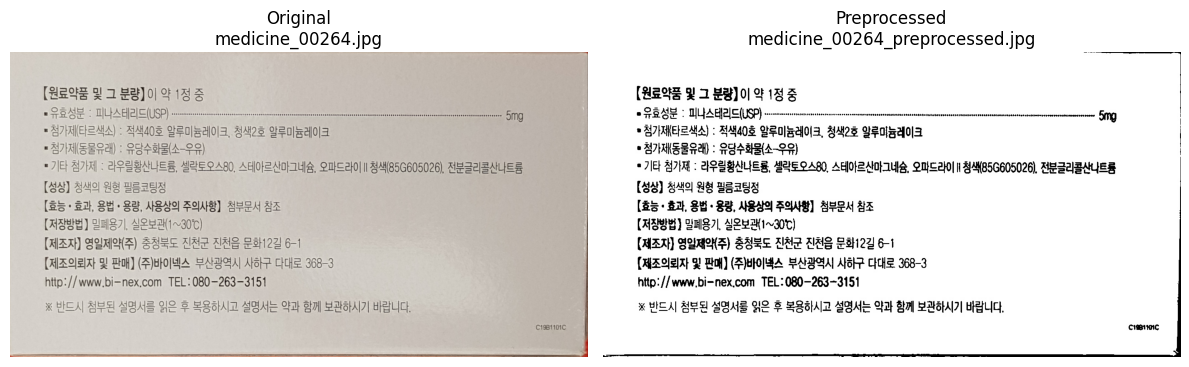

[입력 ] /content/data/원천데이터/TS1/train/medicine_00264.jpg
[출력 ] /content/data/preview/medicine_00264_preprocessed.jpg


In [14]:
PREVIEW_DIR = Path("/content/data/preview")
PREVIEW_DIR.mkdir(parents=True, exist_ok=True)

# 하나 뽑아서 보기
def list_jpgs(root: Path):
    return [p for p in root.rglob("*.jpg") if p.suffix.lower() in IMG_EXTS]

def show_random_preprocess():
    # train/val/test 전체에서 무작위 1장
    all_imgs = list_jpgs(RAW_SPLIT_IMG_ROOT)
    if not all_imgs:
        raise FileNotFoundError(f"이미지를 찾을 수 없음: {RAW_SPLIT_IMG_ROOT}")

    img_path = random.choice(all_imgs)

    # 출력 경로
    out_path = PREVIEW_DIR / f"{img_path.stem}_preprocessed.jpg"

    # 전처리 실행 (저장까지 수행)
    _ = preprocess_image_pipeline(input_path=img_path, output_path=out_path)

    # 시각화: 원본(BGR→RGB), 전처리(단일채널→RGB 변환)
    orig = safe_imread(img_path)
    if orig is None:
        raise FileNotFoundError(f"이미지 로드 실패: {img_path}")
    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    proc = cv2.imdecode(np.fromfile(str(out_path), dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    if proc is None:
        raise FileNotFoundError(f"전처리 결과 로드 실패: {out_path}")
    if proc.ndim == 2:
        proc_rgb = cv2.cvtColor(proc, cv2.COLOR_GRAY2RGB)
    else:
        proc_rgb = cv2.cvtColor(proc, cv2.COLOR_BGR2RGB)

    # 플롯
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(orig_rgb); plt.title(f"Original\n{img_path.name}"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(proc_rgb); plt.title(f"Preprocessed\n{out_path.name}"); plt.axis("off")
    plt.tight_layout()
    plt.show()

    print("[입력 ]", img_path)
    print("[출력 ]", out_path)

# 실행
show_random_preprocess()

### 사전학습 PaddleOCR (추론만)

In [15]:
# GPU/CPU 자동 감지
def detect_gpu():
    try:
        output = subprocess.check_output("nvidia-smi", shell=True, stderr=subprocess.STDOUT)
        return True
    except subprocess.CalledProcessError:
        return False

USE_GPU = detect_gpu()
print(f"[INFO] GPU 사용 여부: {USE_GPU}")

[INFO] GPU 사용 여부: True


In [16]:
# 폰트 다운로드 (한글 폰트)
!wget -q https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf -O /content/NanumGothic.ttf
FONT_PATH = "/content/NanumGothic.ttf"

In [17]:
ocr = PaddleOCR(
    use_angle_cls=True,
    lang='korean',
    rec=True,
    det=True,
    use_gpu=USE_GPU
)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/multilingual/Multilingual_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer/Multilingual_PP-OCRv3_det_infer.tar


100%|██████████| 3.85M/3.85M [00:00<00:00, 4.97MiB/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv4/multilingual/korean_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/korean/korean_PP-OCRv4_rec_infer/korean_PP-OCRv4_rec_infer.tar


100%|██████████| 24.4M/24.4M [00:01<00:00, 13.0MiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:00<00:00, 3.23MiB/s]

[2025/08/14 01:11:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/korean/korean_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec

In [18]:
def run_inference_and_visualize(img_path, output_dir):
    img_save_dir = Path(output_dir) / "images"
    csv_save_dir = Path(output_dir) / "csv"
    img_save_dir.mkdir(parents=True, exist_ok=True)
    csv_save_dir.mkdir(parents=True, exist_ok=True)

    # RAW에서 바로 읽기
    image = safe_imread(img_path)
    if image is None:
        raise FileNotFoundError(f"이미지 로드 실패: {img_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # PaddleOCR 추론
    result = ocr.ocr(str(img_path), cls=True)

    # 가드
    boxes, txts, scores = [], [], []
    if result and isinstance(result, list) and len(result)>0 and result[0]:
        for line in (result[0] or []):
            if not line or len(line)!=2:
                continue
            box, ts = line
            if ts is None or not isinstance(ts, (list, tuple)) or len(ts)!=2:
                continue
            txt, score = ts
            try:
                score = float(score)
            except Exception:
                score = 0.0
            txt = "" if txt is None else str(txt)
            # box 유효성
            if not box or any(not isinstance(pt,(list,tuple)) or len(pt)!=2 for pt in box):
                continue
            boxes.append(box); txts.append(txt); scores.append(score)

    # 시각화
    if len(boxes)>0:
        vis = draw_ocr(image_rgb, boxes, txts, scores, font_path=FONT_PATH)
        im_show = Image.fromarray(vis)
    else:
        im_show = Image.fromarray(image_rgb)

    stem = Path(img_path).stem
    save_img_path = img_save_dir / f"{stem}_ocr_result.jpg"
    save_csv_path = csv_save_dir / f"{stem}_ocr_result.csv"

    # 이미지 저장
    im_show.save(save_img_path)

    # CSV 저장 (빈 결과도 헤더는 씀)
    with open(save_csv_path, 'w', newline='', encoding='utf-8-sig') as f:
        w = csv.writer(f)
        w.writerow(["x1","y1","x2","y2","x3","y3","x4","y4","text","score"])
        for box, txt, score in zip(boxes, txts, scores):
            flat = []
            for pt in box:
                try:
                    x,y = float(pt[0]), float(pt[1])
                except Exception:
                    x,y = 0.0, 0.0
                flat += [x,y]
            if len(flat)!=8:
                flat = (flat + [0.0]*(8-len(flat)))[:8]
            w.writerow(flat + [txt, score])

    return save_img_path, save_csv_path

In [19]:
val_dir = RAW_SPLIT_IMG_ROOT / "val"
output_dir = PRETRAINED_OUT_DIR

val_images = [p for p in val_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
for img_path in tqdm(val_images, desc="PaddleOCR Pretrained Inference", unit="img"):
    try:
        run_inference_and_visualize(img_path, output_dir)
    except Exception as e:
        print(f"[ERROR] {img_path.name} 처리 중 오류: {e}")

PaddleOCR Pretrained Inference:   0%|          | 0/38 [00:00<?, ?img/s]

[2025/08/14 01:11:50] ppocr DEBUG: dt_boxes num : 85, elapsed : 1.8638291358947754
[2025/08/14 01:11:50] ppocr DEBUG: cls num  : 85, elapsed : 0.2848093509674072
[2025/08/14 01:11:51] ppocr DEBUG: rec_res num  : 85, elapsed : 0.9003841876983643


PaddleOCR Pretrained Inference:   3%|▎         | 1/38 [00:03<02:05,  3.40s/img]

[2025/08/14 01:11:51] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.06171679496765137
[2025/08/14 01:11:51] ppocr DEBUG: cls num  : 9, elapsed : 0.03173422813415527
[2025/08/14 01:11:51] ppocr DEBUG: rec_res num  : 9, elapsed : 0.12801694869995117


PaddleOCR Pretrained Inference:   5%|▌         | 2/38 [00:03<00:59,  1.64s/img]

[2025/08/14 01:11:51] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.054804086685180664
[2025/08/14 01:11:52] ppocr DEBUG: cls num  : 33, elapsed : 0.045304298400878906
[2025/08/14 01:11:52] ppocr DEBUG: rec_res num  : 33, elapsed : 0.2657477855682373


PaddleOCR Pretrained Inference:   8%|▊         | 3/38 [00:04<00:40,  1.15s/img]

[2025/08/14 01:11:52] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.05831599235534668
[2025/08/14 01:11:52] ppocr DEBUG: cls num  : 9, elapsed : 0.020161151885986328
[2025/08/14 01:11:52] ppocr DEBUG: rec_res num  : 9, elapsed : 0.08563518524169922


PaddleOCR Pretrained Inference:  11%|█         | 4/38 [00:04<00:29,  1.14img/s]

[2025/08/14 01:11:53] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.06582236289978027
[2025/08/14 01:11:53] ppocr DEBUG: cls num  : 13, elapsed : 0.02772355079650879
[2025/08/14 01:11:53] ppocr DEBUG: rec_res num  : 13, elapsed : 0.13158702850341797


PaddleOCR Pretrained Inference:  13%|█▎        | 5/38 [00:05<00:24,  1.33img/s]

[2025/08/14 01:11:53] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.06380128860473633
[2025/08/14 01:11:53] ppocr DEBUG: cls num  : 37, elapsed : 0.06732892990112305
[2025/08/14 01:11:54] ppocr DEBUG: rec_res num  : 37, elapsed : 0.346940279006958


PaddleOCR Pretrained Inference:  16%|█▌        | 6/38 [00:06<00:24,  1.28img/s]

[2025/08/14 01:11:54] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.0756673812866211
[2025/08/14 01:11:54] ppocr DEBUG: cls num  : 11, elapsed : 0.03721141815185547
[2025/08/14 01:11:54] ppocr DEBUG: rec_res num  : 11, elapsed : 0.09661197662353516


PaddleOCR Pretrained Inference:  18%|█▊        | 7/38 [00:06<00:20,  1.50img/s]

[2025/08/14 01:11:54] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.07721090316772461
[2025/08/14 01:11:55] ppocr DEBUG: cls num  : 38, elapsed : 0.1073143482208252
[2025/08/14 01:11:55] ppocr DEBUG: rec_res num  : 38, elapsed : 0.31682467460632324


PaddleOCR Pretrained Inference:  21%|██        | 8/38 [00:07<00:21,  1.39img/s]

[2025/08/14 01:11:55] ppocr DEBUG: dt_boxes num : 51, elapsed : 0.03851747512817383
[2025/08/14 01:11:55] ppocr DEBUG: cls num  : 51, elapsed : 0.07166051864624023
[2025/08/14 01:11:56] ppocr DEBUG: rec_res num  : 51, elapsed : 0.3719360828399658


PaddleOCR Pretrained Inference:  24%|██▎       | 9/38 [00:08<00:22,  1.26img/s]

[2025/08/14 01:11:56] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.048799753189086914
[2025/08/14 01:11:56] ppocr DEBUG: cls num  : 44, elapsed : 0.06097126007080078
[2025/08/14 01:11:57] ppocr DEBUG: rec_res num  : 44, elapsed : 0.3327462673187256


PaddleOCR Pretrained Inference:  26%|██▋       | 10/38 [00:09<00:21,  1.33img/s]

[2025/08/14 01:11:57] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.024876117706298828
[2025/08/14 01:11:57] ppocr DEBUG: cls num  : 11, elapsed : 0.0165557861328125
[2025/08/14 01:11:57] ppocr DEBUG: rec_res num  : 11, elapsed : 0.10010290145874023


PaddleOCR Pretrained Inference:  29%|██▉       | 11/38 [00:09<00:16,  1.63img/s]

[2025/08/14 01:11:57] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.0482935905456543
[2025/08/14 01:11:57] ppocr DEBUG: cls num  : 44, elapsed : 0.06079244613647461
[2025/08/14 01:11:58] ppocr DEBUG: rec_res num  : 44, elapsed : 0.3314042091369629


PaddleOCR Pretrained Inference:  32%|███▏      | 12/38 [00:10<00:16,  1.54img/s]

[2025/08/14 01:11:58] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.04024505615234375
[2025/08/14 01:11:58] ppocr DEBUG: cls num  : 6, elapsed : 0.01037454605102539
[2025/08/14 01:11:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.11541748046875


PaddleOCR Pretrained Inference:  34%|███▍      | 13/38 [00:10<00:13,  1.79img/s]

[2025/08/14 01:11:58] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.024647235870361328
[2025/08/14 01:11:58] ppocr DEBUG: cls num  : 10, elapsed : 0.028286457061767578
[2025/08/14 01:11:58] ppocr DEBUG: rec_res num  : 10, elapsed : 0.08757162094116211


PaddleOCR Pretrained Inference:  37%|███▋      | 14/38 [00:10<00:11,  2.11img/s]

[2025/08/14 01:11:58] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.041524410247802734
[2025/08/14 01:11:58] ppocr DEBUG: cls num  : 9, elapsed : 0.01660609245300293
[2025/08/14 01:11:59] ppocr DEBUG: rec_res num  : 9, elapsed : 0.09026002883911133


PaddleOCR Pretrained Inference:  39%|███▉      | 15/38 [00:11<00:09,  2.35img/s]

[2025/08/14 01:11:59] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.03211498260498047
[2025/08/14 01:11:59] ppocr DEBUG: cls num  : 4, elapsed : 0.01023411750793457
[2025/08/14 01:11:59] ppocr DEBUG: rec_res num  : 4, elapsed : 0.03462648391723633


PaddleOCR Pretrained Inference:  42%|████▏     | 16/38 [00:11<00:08,  2.71img/s]

[2025/08/14 01:11:59] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.026713132858276367
[2025/08/14 01:11:59] ppocr DEBUG: cls num  : 8, elapsed : 0.015946626663208008
[2025/08/14 01:11:59] ppocr DEBUG: rec_res num  : 8, elapsed : 0.07228565216064453


PaddleOCR Pretrained Inference:  45%|████▍     | 17/38 [00:11<00:07,  2.92img/s]

[2025/08/14 01:11:59] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.05767679214477539
[2025/08/14 01:11:59] ppocr DEBUG: cls num  : 4, elapsed : 0.011627912521362305
[2025/08/14 01:11:59] ppocr DEBUG: rec_res num  : 4, elapsed : 0.04400515556335449


PaddleOCR Pretrained Inference:  47%|████▋     | 18/38 [00:11<00:06,  3.25img/s]

[2025/08/14 01:11:59] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.053037166595458984
[2025/08/14 01:12:00] ppocr DEBUG: cls num  : 46, elapsed : 0.07719087600708008
[2025/08/14 01:12:00] ppocr DEBUG: rec_res num  : 46, elapsed : 0.3408834934234619


PaddleOCR Pretrained Inference:  50%|█████     | 19/38 [00:12<00:08,  2.35img/s]

[2025/08/14 01:12:00] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.029905080795288086
[2025/08/14 01:12:00] ppocr DEBUG: cls num  : 8, elapsed : 0.015747785568237305
[2025/08/14 01:12:00] ppocr DEBUG: rec_res num  : 8, elapsed : 0.07199597358703613


PaddleOCR Pretrained Inference:  53%|█████▎    | 20/38 [00:12<00:06,  2.58img/s]

[2025/08/14 01:12:00] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.04100823402404785
[2025/08/14 01:12:00] ppocr DEBUG: cls num  : 16, elapsed : 0.023450374603271484
[2025/08/14 01:12:01] ppocr DEBUG: rec_res num  : 16, elapsed : 0.11102008819580078


PaddleOCR Pretrained Inference:  55%|█████▌    | 21/38 [00:13<00:06,  2.71img/s]

[2025/08/14 01:12:01] ppocr DEBUG: dt_boxes num : 69, elapsed : 0.04706978797912598
[2025/08/14 01:12:01] ppocr DEBUG: cls num  : 69, elapsed : 0.09115123748779297
[2025/08/14 01:12:02] ppocr DEBUG: rec_res num  : 69, elapsed : 0.4827306270599365


PaddleOCR Pretrained Inference:  58%|█████▊    | 22/38 [00:14<00:09,  1.69img/s]

[2025/08/14 01:12:02] ppocr DEBUG: dt_boxes num : 98, elapsed : 0.05486702919006348
[2025/08/14 01:12:02] ppocr DEBUG: cls num  : 98, elapsed : 0.14144682884216309
[2025/08/14 01:12:03] ppocr DEBUG: rec_res num  : 98, elapsed : 0.6921069622039795


PaddleOCR Pretrained Inference:  61%|██████    | 23/38 [00:15<00:12,  1.17img/s]

[2025/08/14 01:12:03] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.04704022407531738
[2025/08/14 01:12:03] ppocr DEBUG: cls num  : 8, elapsed : 0.0157625675201416
[2025/08/14 01:12:04] ppocr DEBUG: rec_res num  : 8, elapsed : 0.0719749927520752


PaddleOCR Pretrained Inference:  63%|██████▎   | 24/38 [00:16<00:09,  1.40img/s]

[2025/08/14 01:12:04] ppocr DEBUG: dt_boxes num : 51, elapsed : 0.049066781997680664
[2025/08/14 01:12:04] ppocr DEBUG: cls num  : 51, elapsed : 0.08449506759643555
[2025/08/14 01:12:04] ppocr DEBUG: rec_res num  : 51, elapsed : 0.37023329734802246


PaddleOCR Pretrained Inference:  66%|██████▌   | 25/38 [00:16<00:09,  1.33img/s]

[2025/08/14 01:12:05] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.026165246963500977
[2025/08/14 01:12:05] ppocr DEBUG: cls num  : 24, elapsed : 0.041030168533325195
[2025/08/14 01:12:05] ppocr DEBUG: rec_res num  : 24, elapsed : 0.1860034465789795


PaddleOCR Pretrained Inference:  68%|██████▊   | 26/38 [00:17<00:07,  1.51img/s]

[2025/08/14 01:12:05] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.040189266204833984
[2025/08/14 01:12:05] ppocr DEBUG: cls num  : 4, elapsed : 0.010035991668701172
[2025/08/14 01:12:05] ppocr DEBUG: rec_res num  : 4, elapsed : 0.05181741714477539


PaddleOCR Pretrained Inference:  71%|███████   | 27/38 [00:17<00:06,  1.78img/s]

[2025/08/14 01:12:06] ppocr DEBUG: dt_boxes num : 53, elapsed : 0.19349145889282227
[2025/08/14 01:12:06] ppocr DEBUG: cls num  : 53, elapsed : 0.21370792388916016
[2025/08/14 01:12:07] ppocr DEBUG: rec_res num  : 53, elapsed : 1.1709437370300293


PaddleOCR Pretrained Inference:  74%|███████▎  | 28/38 [00:20<00:10,  1.09s/img]

[2025/08/14 01:12:08] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.10274767875671387
[2025/08/14 01:12:08] ppocr DEBUG: cls num  : 10, elapsed : 0.072845458984375
[2025/08/14 01:12:09] ppocr DEBUG: rec_res num  : 10, elapsed : 0.2632603645324707


PaddleOCR Pretrained Inference:  76%|███████▋  | 29/38 [00:21<00:09,  1.10s/img]

[2025/08/14 01:12:09] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.06760215759277344
[2025/08/14 01:12:09] ppocr DEBUG: cls num  : 3, elapsed : 0.021248817443847656
[2025/08/14 01:12:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.0836937427520752


PaddleOCR Pretrained Inference:  79%|███████▉  | 30/38 [00:21<00:07,  1.07img/s]

[2025/08/14 01:12:10] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.06197643280029297
[2025/08/14 01:12:10] ppocr DEBUG: cls num  : 8, elapsed : 0.02665400505065918
[2025/08/14 01:12:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.10109353065490723


PaddleOCR Pretrained Inference:  82%|████████▏ | 31/38 [00:22<00:06,  1.12img/s]

[2025/08/14 01:12:10] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.03607296943664551
[2025/08/14 01:12:10] ppocr DEBUG: cls num  : 7, elapsed : 0.014772176742553711
[2025/08/14 01:12:10] ppocr DEBUG: rec_res num  : 7, elapsed : 0.10401248931884766


PaddleOCR Pretrained Inference:  84%|████████▍ | 32/38 [00:22<00:04,  1.40img/s]

[2025/08/14 01:12:10] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.040772199630737305
[2025/08/14 01:12:11] ppocr DEBUG: cls num  : 12, elapsed : 0.016381263732910156
[2025/08/14 01:12:11] ppocr DEBUG: rec_res num  : 12, elapsed : 0.1104280948638916


PaddleOCR Pretrained Inference:  87%|████████▋ | 33/38 [00:23<00:03,  1.64img/s]

[2025/08/14 01:12:11] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.05102038383483887
[2025/08/14 01:12:11] ppocr DEBUG: cls num  : 21, elapsed : 0.031033754348754883
[2025/08/14 01:12:11] ppocr DEBUG: rec_res num  : 21, elapsed : 0.19400358200073242


PaddleOCR Pretrained Inference:  89%|████████▉ | 34/38 [00:23<00:02,  1.70img/s]

[2025/08/14 01:12:11] ppocr DEBUG: dt_boxes num : 58, elapsed : 0.05928826332092285
[2025/08/14 01:12:12] ppocr DEBUG: cls num  : 58, elapsed : 0.07660222053527832
[2025/08/14 01:12:12] ppocr DEBUG: rec_res num  : 58, elapsed : 0.43971776962280273


PaddleOCR Pretrained Inference:  92%|█████████▏| 35/38 [00:24<00:02,  1.47img/s]

[2025/08/14 01:12:12] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.05432891845703125
[2025/08/14 01:12:12] ppocr DEBUG: cls num  : 7, elapsed : 0.015346288681030273
[2025/08/14 01:12:12] ppocr DEBUG: rec_res num  : 7, elapsed : 0.10363078117370605


PaddleOCR Pretrained Inference:  95%|█████████▍| 36/38 [00:25<00:01,  1.67img/s]

[2025/08/14 01:12:13] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.04294633865356445
[2025/08/14 01:12:13] ppocr DEBUG: cls num  : 9, elapsed : 0.0530085563659668
[2025/08/14 01:12:13] ppocr DEBUG: rec_res num  : 9, elapsed : 0.10268950462341309


PaddleOCR Pretrained Inference:  97%|█████████▋| 37/38 [00:25<00:00,  1.82img/s]

[2025/08/14 01:12:13] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.10942673683166504
[2025/08/14 01:12:14] ppocr DEBUG: cls num  : 26, elapsed : 0.08483672142028809
[2025/08/14 01:12:14] ppocr DEBUG: rec_res num  : 26, elapsed : 0.4784407615661621


PaddleOCR Pretrained Inference: 100%|██████████| 38/38 [00:26<00:00,  1.41img/s]




---



### 사전학습 에러 분석

In [21]:
CSV_DIR = Path("/content/pretrained_results/csv")
REPORT_DIR = Path("/content/pretrained_results/report")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

SCORE_TH = 0.7

In [22]:
rows = []
csv_files = sorted(CSV_DIR.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"예측 CSV가 없습니다: {CSV_DIR}")

for csvf in csv_files:
    df = pd.read_csv(csvf)
    # 좌표/텍스트/점수 컬럼 고정
    cols = ["x1","y1","x2","y2","x3","y3","x4","y4","text","score"]
    if not set(cols).issubset(df.columns):
        print(f"[WARN] 누락 컬럼으로 스킵: {csvf.name} -> {sorted(set(cols)-set(df.columns))}")
        continue

    df = df[cols].copy()
    df["image_id"] = csvf.stem.replace("_ocr_result","")

    # bbox 특성(대략치): 너비/높이/면적/종횡비
    xs = df[["x1","x2","x3","x4"]].to_numpy()
    ys = df[["y1","y2","y3","y4"]].to_numpy()
    w = xs.max(axis=1) - xs.min(axis=1)
    h = ys.max(axis=1) - ys.min(axis=1)
    area = w * h
    aspect = np.divide(w, np.maximum(h, 1))

    df["width_px"]  = w
    df["height_px"] = h
    df["area_px"]   = area
    df["aspect"]    = aspect
    df["text_len"]  = df["text"].astype(str).str.len()

    # 특수 패턴 플래그
    df["has_hyphen"] = df["text"].astype(str).str.contains(r"[-–—]", regex=True)
    df["has_symbol"] = df["text"].astype(str).str.contains(r"[^\w\s가-힣]", regex=True)

    rows.append(df)

all_df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=[
    "x1","y1","x2","y2","x3","y3","x4","y4","text","score","image_id",
    "width_px","height_px","area_px","aspect","text_len","has_hyphen","has_symbol"
])

# 저신뢰만 필터
low = all_df[all_df["score"] <= SCORE_TH].copy()

# 요약 1) 이미지별 저신뢰 개수
per_image = (low.groupby("image_id")
             .size()
             .reset_index(name="low_conf_cnt")
             .sort_values("low_conf_cnt", ascending=False))

# 요약 2) 패턴/크기별 통계
summary = {
    "total_preds": [len(all_df)],
    "low_conf_preds": [len(low)],
    "low_conf_rate(%)": [round(100*len(low)/max(len(all_df),1),2)],
    "median_height_low": [float(low["height_px"].median() if len(low) else 0)],
    "median_width_low":  [float(low["width_px"].median() if len(low) else 0)],
    "has_hyphen_rate_low(%)": [round(100*low["has_hyphen"].mean(),2) if len(low) else 0],
    "has_symbol_rate_low(%)": [round(100*low["has_symbol"].mean(),2) if len(low) else 0],
    "text_len_median_low": [float(low["text_len"].median() if len(low) else 0)],
}
summary_df = pd.DataFrame(summary)

# 저장
low_path = REPORT_DIR / "low_confidence_details.csv"
per_image_path = REPORT_DIR / "low_confidence_per_image.csv"
summary_path = REPORT_DIR / "low_confidence_summary.csv"

low.to_csv(low_path, index=False, encoding="utf-8-sig")
per_image.to_csv(per_image_path, index=False, encoding="utf-8-sig")
summary_df.to_csv(summary_path, index=False, encoding="utf-8-sig")

print("[저장] 자세한 목록:", low_path)
print("[저장] 이미지별 개수:", per_image_path)
print("[저장] 요약 통계:", summary_path)

# 화면 출력
print("\n=== 요약 ===")
print(summary_df.to_string(index=False))

print("\n=== 상위 문제 이미지 10개 ===")
print(per_image.head(10).to_string(index=False))

print("\n=== 예시(점수 낮은 상위 10개) ===")
print(low.sort_values("score")
        .head(10)[["image_id","text","score","width_px","height_px","has_hyphen","has_symbol","text_len"]]
        .to_string(index=False))

[저장] 자세한 목록: /content/pretrained_results/report/low_confidence_details.csv
[저장] 이미지별 개수: /content/pretrained_results/report/low_confidence_per_image.csv
[저장] 요약 통계: /content/pretrained_results/report/low_confidence_summary.csv

=== 요약 ===
 total_preds  low_conf_preds  low_conf_rate(%)  median_height_low  median_width_low  has_hyphen_rate_low(%)  has_symbol_rate_low(%)  text_len_median_low
         893              67               7.5               77.0             216.0                    7.46                   16.42                  2.0

=== 상위 문제 이미지 10개 ===
      image_id  low_conf_cnt
medicine_00034             6
medicine_00619             6
medicine_00530             6
medicine_00620             5
medicine_00268             5
medicine_00555             5
medicine_00591             4
medicine_00279             4
medicine_00363             4
medicine_00414             3

=== 예시(점수 낮은 상위 10개) ===
      image_id  text    score  width_px  height_px  has_hyphen  has_symbol  text_len
me

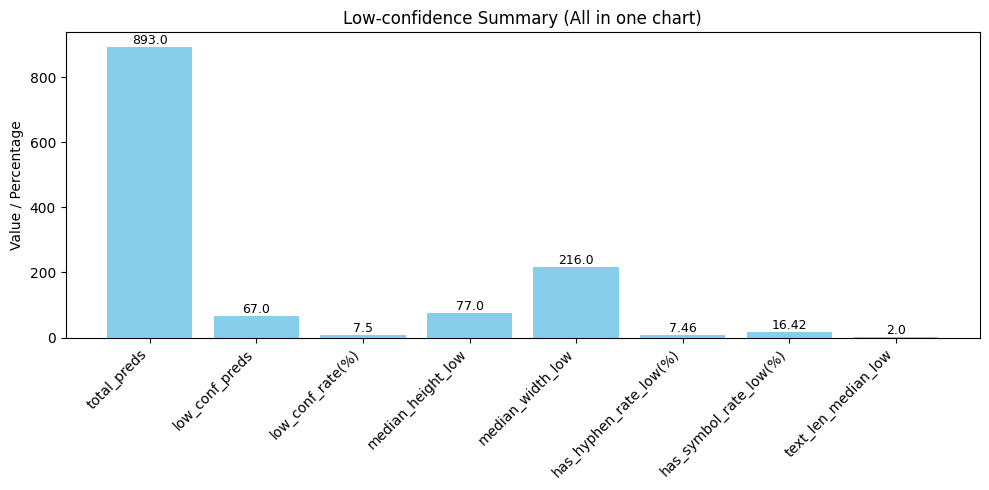

In [23]:
row = summary_df.iloc[0].to_dict()

# 키: 값 형태로 변환 (dict -> list)
labels = list(row.keys())
values = list(row.values())

# 그래프 그리기
plt.figure(figsize=(10,5))
bars = plt.bar(labels, values, color='skyblue')

# 값 표시
for b, v in zip(bars, values):
    plt.text(b.get_x() + b.get_width()/2, v, f"{v}",
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.title("Low-confidence Summary (All in one chart)")
plt.ylabel("Value / Percentage")
plt.tight_layout()
plt.show()



---



### 에러 상세분석

#### 1. 전체 예측 대비 저신뢰 비율
- 전체 예측 수: 893.0

- 저신뢰 예측 수: 67

- 저신뢰 비율: 7.5%
→ 전체 중 약 7% 이상이 confidence threshold 이하로 판정됨.

#### 2. 저신뢰 박스 특성

- 하이픈 포함 비율: 7.46%

- 특수문자 포함 비율: 16.42%
→ 특수문자(%, 숫자+기호 등) 포함된 경우가 5건 중 1건꼴로 나타남

- 텍스트 길이 중앙값: 3글자
→ 짧은 단어(2~4글자)가 다수



---



### CER/WER 평가 (사전학습) -> mini dataset 기준

In [44]:
def calculate_cer(pred, gt):
    """Calculate Character Error Rate"""
    if len(gt) == 0:
        return 1.0 if len(pred) > 0 else 0.0

    # Dynamic programming for edit distance
    dp = [[0] * (len(gt) + 1) for _ in range(len(pred) + 1)]

    for i in range(len(pred) + 1):
        dp[i][0] = i
    for j in range(len(gt) + 1):
        dp[0][j] = j

    for i in range(1, len(pred) + 1):
        for j in range(1, len(gt) + 1):
            if pred[i-1] == gt[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1]) + 1

    return dp[len(pred)][len(gt)] / len(gt)

def calculate_wer(pred, gt):
    """Calculate Word Error Rate"""
    pred_words = pred.split()
    gt_words = gt.split()

    if len(gt_words) == 0:
        return 1.0 if len(pred_words) > 0 else 0.0

    # Dynamic programming for edit distance
    dp = [[0] * (len(gt_words) + 1) for _ in range(len(pred_words) + 1)]

    for i in range(len(pred_words) + 1):
        dp[i][0] = i
    for j in range(len(gt_words) + 1):
        dp[0][j] = j

    for i in range(1, len(pred_words) + 1):
        for j in range(1, len(gt_words) + 1):
            if pred_words[i-1] == gt_words[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1]) + 1

    return dp[len(pred_words)][len(gt_words)] / len(gt_words)

def clean_text(text):
    """Clean text for comparison"""
    if not text:
        return ""
    # Remove extra whitespace and normalize
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def evaluate_paddleocr():
    # Initialize PaddleOCR
    USE_GPU = detect_gpu()
    print(f"[INFO] Using GPU: {USE_GPU}")

    ocr = PaddleOCR(
        use_angle_cls=True,
        lang='korean',
        rec=True,
        det=True,
        use_gpu=USE_GPU,
        show_log=False
    )

    # Load validation data
    val_txt_path = Path("/content/recdata/val.mini.txt")
    if not val_txt_path.exists():
        print(f"[ERROR] {val_txt_path} not found!")
        return

    # Read validation samples
    samples = []
    with open(val_txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if '\t' in line:
                img_path, gt_text = line.split('\t', 1)
                samples.append((img_path, gt_text))

    print(f"[INFO] Evaluating {len(samples)} validation samples...")

    total_cer = 0.0
    total_wer = 0.0
    valid_samples = 0

    results = []

    for img_path, gt_text in tqdm(samples, desc="Evaluating"):
        try:
            # Run OCR
            result = ocr.ocr(img_path, cls=True)

            # Extract predicted text
            pred_text = ""
            if result and result[0]:
                for line in result[0]:
                    if len(line) >= 2:
                        pred_text += line[1][0] + " "

            pred_text = clean_text(pred_text)
            gt_text = clean_text(gt_text)

            # Calculate metrics
            cer = calculate_cer(pred_text, gt_text)
            wer = calculate_wer(pred_text, gt_text)

            total_cer += cer
            total_wer += wer
            valid_samples += 1

            results.append({
                'image': Path(img_path).name,
                'ground_truth': gt_text,
                'prediction': pred_text,
                'cer': cer,
                'wer': wer
            })

            # Print first few examples
            if valid_samples <= 5:
                print(f"\n[Sample {valid_samples}]")
                print(f"GT:   '{gt_text}'")
                print(f"Pred: '{pred_text}'")
                print(f"CER: {cer:.3f}, WER: {wer:.3f}")

        except Exception as e:
            print(f"[ERROR] Failed to process {img_path}: {e}")
            continue

    if valid_samples > 0:
        avg_cer = total_cer / valid_samples
        avg_wer = total_wer / valid_samples

        print(f"\n{'='*50}")
        print(f"[RESULTS] Pretrained PaddleOCR Performance")
        print(f"{'='*50}")
        print(f"Samples evaluated: {valid_samples}")
        print(f"Average CER: {avg_cer:.3f} ({avg_cer*100:.1f}%)")
        print(f"Average WER: {avg_wer:.3f} ({avg_wer*100:.1f}%)")
        print(f"{'='*50}")

        # Save detailed results
        results_path = Path("/content/pretrained_ocr_results.txt")
        with open(results_path, 'w', encoding='utf-8') as f:
            f.write(f"Pretrained PaddleOCR Evaluation Results\n")
            f.write(f"Average CER: {avg_cer:.3f} ({avg_cer*100:.1f}%)\n")
            f.write(f"Average WER: {avg_wer:.3f} ({avg_wer*100:.1f}%)\n\n")

            for result in results:
                f.write(f"Image: {result['image']}\n")
                f.write(f"GT:   {result['ground_truth']}\n")
                f.write(f"Pred: {result['prediction']}\n")
                f.write(f"CER: {result['cer']:.3f}, WER: {result['wer']:.3f}\n\n")

        print(f"[INFO] Detailed results saved to {results_path}")
    else:
        print("[ERROR] No valid samples processed!")

if __name__ == "__main__":
    evaluate_paddleocr()

[INFO] Using GPU: True
[INFO] Evaluating 200 validation samples...


Evaluating:   1%|          | 2/200 [00:00<00:12, 15.42it/s]


[Sample 1]
GT:   '환자로서,'
Pred: '환자로서'
CER: 0.200, WER: 1.000

[Sample 2]
GT:   '관계없이'
Pred: '평고'
CER: 1.000, WER: 1.000

[Sample 3]
GT:   '제조번호'
Pred: '제조번호'
CER: 0.000, WER: 0.000


Evaluating:   2%|▎         | 5/200 [00:00<00:09, 21.33it/s]


[Sample 4]
GT:   'DC716'
Pred: 'Dc716'
CER: 0.200, WER: 1.000

[Sample 5]
GT:   '유효성이'
Pred: '유효성이'
CER: 0.000, WER: 0.000


Evaluating: 100%|██████████| 200/200 [00:09<00:00, 22.09it/s]



[RESULTS] Pretrained PaddleOCR Performance
Samples evaluated: 200
Average CER: 0.387 (38.7%)
Average WER: 0.845 (84.5%)
[INFO] Detailed results saved to /content/pretrained_ocr_results.txt




---



### 학습된 PaddleOCR(FT)
작은 글씨/기호 조합 문제가 가장많음

- 인식기(REC) 위주 파인튜닝
- 사전(딕셔너리) 보강 + 인식 전용 파인튜닝



#### 후처리

In [25]:
IMG_ROOT = Path("/content/data/원천데이터/TS1")          # images:   TS1/{train,val}
ANN_ROOT = Path("/content/data/라벨링데이터/TL1")        # labels:   TL1/{train,val}
MANIFEST_DIR = Path("/content/manifests")                # split_{train,val}.csv (optional)

OUT_ROOT = Path("/content/recdata")
(OUT_ROOT/"train/imgs").mkdir(parents=True, exist_ok=True)
(OUT_ROOT/"val/imgs").mkdir(parents=True, exist_ok=True)

In [26]:
def safe_imread(p):
    p = str(p)
    data = np.fromfile(p, dtype=np.uint8)
    return cv2.imdecode(data, cv2.IMREAD_COLOR)

def safe_imsave(p, img):
    p = Path(p); p.parent.mkdir(parents=True, exist_ok=True)
    ok, buf = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
    if ok: buf.tofile(str(p))

def resize_for_ocr(img, target_height=64, target_width=320):
    """
    Resize image for OCR while maintaining aspect ratio and adding padding.
    Args:
        img: Input image (numpy array)
        target_height: Target height (default: 64)
        target_width: Target width (default: 320)
    Returns:
        Resized image with padding
    """
    if img is None or img.size == 0:
        return None

    h, w = img.shape[:2]

    # Calculate scale to fit within target dimensions
    scale = min(target_height / h, target_width / w)
    new_h, new_w = int(h * scale), int(w * scale)

    # Resize image
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create canvas with target size and fill with white background
    canvas = np.ones((target_height, target_width, 3), dtype=np.uint8) * 255

    # Center the resized image on canvas
    y_offset = (target_height - new_h) // 2
    x_offset = (target_width - new_w) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    return canvas

In [27]:
def clip_box(x1, y1, x2, y2, w, h):
    x1 = max(0, min(int(x1), w-1))
    y1 = max(0, min(int(y1), h-1))
    x2 = max(0, min(int(x2), w-1))
    y2 = max(0, min(int(y2), h-1))
    if x2 <= x1: x2 = min(w-1, x1+1)
    if y2 <= y1: y2 = min(h-1, y1+1)
    return x1, y1, x2, y2

def _aabb_from_points(pts):
    xs = [float(p[0]) for p in pts]; ys = [float(p[1]) for p in pts]
    return [min(xs), min(ys), max(xs), max(ys)]

def aabb_from_mixed(bbox):
    """
    bbox → [x1,y1,x2,y2] 변환.
    지원:
      - dict {x,y,width,height}
      - [x,y,w,h]
      - [[x,y], ...]  (polygon/quad)
      - [ {x,y,width,height}, ... ]  (여러 조각 → 합집합)
    """
    def _is_num(x):
        try:
            float(x); return True
        except Exception:
            return False

    def _xywh(x,y,w,h): return [float(x), float(y), float(x)+float(w), float(y)+float(h)]
    def _from_points(pts):
        xs = [float(p[0]) for p in pts]; ys = [float(p[1]) for p in pts]
        return [min(xs), min(ys), max(xs), max(ys)]
    def _union(boxes):
        xs1=[b[0] for b in boxes]; ys1=[b[1] for b in boxes]
        xs2=[b[2] for b in boxes]; ys2=[b[3] for b in boxes]
        return [min(xs1), min(ys1), max(xs2), max(ys2)]

    # dict
    if isinstance(bbox, dict):
        x=bbox.get("x", bbox.get("left")); y=bbox.get("y", bbox.get("top"))
        w=bbox.get("width", bbox.get("w")); h=bbox.get("height", bbox.get("h"))
        if all(_is_num(v) for v in [x,y,w,h]):
            return _xywh(x,y,w,h)

    # list
    if isinstance(bbox, list):
        # [x,y,w,h]
        if len(bbox)==4 and all(_is_num(v) for v in bbox):
            x,y,w,h = bbox; return _xywh(x,y,w,h)
        # [[x,y], ...]
        if len(bbox)>=2 and all(isinstance(p,(list,tuple)) and len(p)==2 for p in bbox):
            return _from_points(bbox)
        # [ {x,y,width,height}, ... ]  (조각 리스트 → 합집합)
        if len(bbox)>=1 and all(isinstance(it, dict) for it in bbox):
            boxes=[]
            for it in bbox:
                x=it.get("x"); y=it.get("y"); w=it.get("width"); h=it.get("height")
                if None not in (x,y,w,h):
                    boxes.append(_xywh(x,y,w,h))
            if boxes:
                return _union(boxes)

    return None

In [28]:
def parse_gt(json_path: Path):
    """
    네 JSON 구조 전용 파서:
      annotations[*].bbox     : [{'id','x','y','width','height'}, ...]
      annotations[*].polygons : [{'id','points':[[x,y],...], 'text':"...", ...}, ...]
    - text는 polygon['text']
    - bbox는 polygon points로 AABB 계산(정밀), 실패 시 동일 id의 xywh 사용
    return: [{'text': str, 'bbox': [x1,y1,x2,y2]}, ...]
    """
    out = []
    try:
        data = json.loads(json_path.read_text(encoding="utf-8"))
    except Exception:
        return out

    anns = data.get("annotations", [])
    if not isinstance(anns, list) or not anns:
        return out

    for ann in anns:
        # id → xyxy bbox map (from xywh)
        bbox_by_id = {}
        for b in ann.get("bbox", []) or []:
            try:
                _id = b.get("id")
                x, y = float(b.get("x")), float(b.get("y"))
                w, h = float(b.get("width")), float(b.get("height"))
                bbox_by_id[_id] = [x, y, x + w, y + h]
            except Exception:
                continue

        # polygons: use points → AABB (preferred), else fall back to bbox_by_id
        for poly in ann.get("polygons", []) or []:
            _id  = poly.get("id")
            text = poly.get("text", "")
            text = "" if text is None else str(text).replace("\t"," ").replace("\n"," ").strip()

            # Skip if empty after cleaning
            if text == "":
                continue

            # Skip if too short (less than 2 characters)
            if len(text) < 2:
                continue

            # Skip if only special characters (no Korean or alphanumeric)
            import re
            if re.match(r'^[^\w가-힣]+$', text):
                continue

            aabb = None
            pts = poly.get("points")
            if isinstance(pts, list) and len(pts) >= 2 and all(isinstance(p,(list,tuple)) and len(p)==2 for p in pts):
                try:
                    aabb = _aabb_from_points(pts)
                except Exception:
                    aabb = None
            if aabb is None:
                aabb = bbox_by_id.get(_id)

            if aabb is not None:
                out.append({"text": text, "bbox": aabb})

    return out

In [29]:
def build_pairs_from_manifest(split):
    pairs = []

    # Always use directory scan approach since manifest paths don't match actual file structure
    img_dir = IMG_ROOT / split
    ann_dir = ANN_ROOT / split

    if not (img_dir.exists() and ann_dir.exists()):
        print(f"[WARNING] Directory not found: {img_dir} or {ann_dir}")
        return pairs

    # Scan directory for image-annotation pairs (stem matching)
    for img_path in img_dir.glob("*.jpg"):
        stem = img_path.stem
        ann_candidates = list(ann_dir.glob(f"{stem}.json"))
        if ann_candidates:
            pairs.append((img_path, ann_candidates[0]))

    print(f"[INFO] Found {len(pairs)} image-annotation pairs in {split}")
    return pairs

def make_rec_split(split, pad_ratio=0.1, min_px=16):
    out_dir = OUT_ROOT/split/"imgs"
    list_path = OUT_ROOT/f"{split}.txt"
    pairs = build_pairs_from_manifest(split)

    n_total = 0
    with open(list_path, "w", encoding="utf-8") as fw:
        for img_path, ann_path in tqdm(pairs, desc=f"Make Rec {split}", unit="img"):
            img = safe_imread(img_path)
            if img is None:
                continue
            H, W = img.shape[:2]
            gts = parse_gt(ann_path)

            for k, it in enumerate(gts):
                x1, y1, x2, y2 = it["bbox"]
                # padding
                pad = int(pad_ratio * max(x2-x1, y2-y1))
                x1p, y1p, x2p, y2p = clip_box(x1-pad, y1-pad, x2+pad, y2+pad, W, H)
                crop = img[y1p:y2p, x1p:x2p]
                if crop.size == 0:
                    continue
                # too small → skip
                if (y2p - y1p) < min_px or (x2p - x1p) < min_px:
                    continue

                crop_resized = resize_for_ocr(crop, target_height=64, target_width=320)
                if crop_resized is None:
                    continue

                out_name = f"{img_path.stem}_{k:04d}.jpg"
                out_path = out_dir / out_name
                safe_imsave(out_path, crop_resized)

                # PaddleOCR Rec format: <abs_path>\t<label>
                fw.write(f"{str(out_path)}\t{it['text']}\n")
                n_total += 1

    return n_total, list_path

In [30]:
train_cnt, train_txt = make_rec_split("train", pad_ratio=0.1, min_px=16)
val_cnt,   val_txt   = make_rec_split("val",   pad_ratio=0.1, min_px=16)
print(f"[DONE] train crops: {train_cnt} → {train_txt}")
print(f"[DONE] val crops:   {val_cnt} → {val_txt}")

[INFO] Found 304 image-annotation pairs in train


Make Rec train: 100%|██████████| 304/304 [00:36<00:00,  8.34img/s]


[INFO] Found 38 image-annotation pairs in val


Make Rec val: 100%|██████████| 38/38 [00:03<00:00, 10.97img/s]

[DONE] train crops: 10462 → /content/recdata/train.txt
[DONE] val crops:   919 → /content/recdata/val.txt


In [31]:
def validate_data_line(line):
    """데이터 라인의 유효성 검사 - 조건 대폭 완화"""
    try:
        parts = line.strip().split('\t')
        if len(parts) != 2:
            return False, "Invalid format (not tab-separated)"

        img_path, text = parts

        # 이미지 파일 존재 확인
        if not Path(img_path).exists():
            return False, f"Image not found: {img_path}"

        img = safe_imread(img_path)
        if img is None:
            return False, f"Cannot read image: {img_path}"

        if not text or not text.strip():
            return False, "Empty text"

        h, w = img.shape[:2]
        if h < 1 or w < 1:
            return False, f"Invalid image size: {w}x{h}"

        return True, "Valid"

    except Exception as e:
        return False, f"Exception: {str(e)}"

def create_clean_files():
    """에러가 있는 데이터는 필터링하고 깨끗한 데이터만 clean.txt에 저장"""
    train_src = Path("/content/recdata/train.txt")
    val_src = Path("/content/recdata/val.txt")

    train_clean = Path("/content/recdata/train.clean.txt")
    val_clean = Path("/content/recdata/val.clean.txt")

    # Train 데이터 검증 및 정리
    if train_src.exists():
        lines = train_src.read_text(encoding='utf-8').splitlines()
        clean_lines = []
        error_count = 0

        print(f"[INFO] Validating {len(lines)} train samples...")
        for i, line in enumerate(lines):
            is_valid, reason = validate_data_line(line)
            if is_valid:
                clean_lines.append(line)
            else:
                error_count += 1
                if error_count <= 5:  # 처음 5개 에러만 출력
                    print(f"[SKIP] Line {i+1}: {reason}")

        train_clean.write_text('\n'.join(clean_lines) + '\n', encoding='utf-8')
        print(f"[INFO] Train: {len(lines)} → {len(clean_lines)} (filtered {error_count} errors)")
    else:
        print(f"[ERROR] {train_src} not found!")

    # Validation 데이터 검증 및 정리
    if val_src.exists():
        lines = val_src.read_text(encoding='utf-8').splitlines()
        clean_lines = []
        error_count = 0

        print(f"[INFO] Validating {len(lines)} val samples...")
        for i, line in enumerate(lines):
            is_valid, reason = validate_data_line(line)
            if is_valid:
                clean_lines.append(line)
            else:
                error_count += 1
                if error_count <= 5:  # 처음 5개 에러만 출력
                    print(f"[SKIP] Line {i+1}: {reason}")

        val_clean.write_text('\n'.join(clean_lines) + '\n', encoding='utf-8')
        print(f"[INFO] Val: {len(lines)} → {len(clean_lines)} (filtered {error_count} errors)")
    else:
        print(f"[ERROR] {val_src} not found!")

    print("[DONE] Clean files created with error filtering")

# 실행
create_clean_files()

[INFO] Validating 10462 train samples...
[INFO] Train: 10462 → 10462 (filtered 0 errors)
[INFO] Validating 919 val samples...
[INFO] Val: 919 → 919 (filtered 0 errors)
[DONE] Clean files created with error filtering


In [32]:
# 미니 데이터셋 생성 (메모리 절약용)
src_tr = Path("/content/recdata/train.clean.txt")
src_va = Path("/content/recdata/val.clean.txt")

tr_lines = src_tr.read_text(encoding="utf-8").splitlines()
va_lines = src_va.read_text(encoding="utf-8").splitlines()

tr_keep = 2000 if len(tr_lines) >= 2000 else len(tr_lines)
va_keep = 200  if len(va_lines) >= 200  else len(va_lines)

random.shuffle(tr_lines)
random.shuffle(va_lines)

Path("/content/recdata/train.mini.txt").write_text("\n".join(tr_lines[:tr_keep]) + "\n", encoding="utf-8")
Path("/content/recdata/val.mini.txt").write_text("\n".join(va_lines[:va_keep]) + "\n", encoding="utf-8")

print("reshuffled mini sets written.")
print(f"Train: {len(tr_lines)} → {tr_keep}")
print(f"Val: {len(va_lines)} → {va_keep}")

reshuffled mini sets written.
Train: 10462 → 2000
Val: 919 → 200


#### 문자집합(사전) 만들기
- train/val 라벨에 실제로 등장하는 문자만 모아 커스텀 charset을 만듭니다.
(숫자·기호·한글·괄호·%·℃ 등 포함)

In [33]:
train_txt = Path("/content/recdata/train.txt")
val_txt   = Path("/content/recdata/val.txt")
charset_path = Path("/content/recdata/charset.txt")

def harvest_chars(list_file: Path):
    chars = set()
    with open(list_file, encoding="utf-8") as f:
        for line in f:
            try:
                _, label = line.rstrip("\n").split("\t", 1)
            except ValueError:
                continue
            # 공백은 PaddleOCR 옵션으로 다룰 수 있으니 일단 그대로 둠
            for ch in label:
                chars.add(ch)
    return chars

chars = harvest_chars(train_txt) | harvest_chars(val_txt)

# 자주 쓰이는 기호들 보강 (누락 시 추가)
extra = list("()-[]{}%℃°/_.·+×=~:,;!?'\"\\|*@#&")
for ch in extra:
    chars.add(ch)

# 줄바꿈 없이 "문자 1개 = 1라인"
with open(charset_path, "w", encoding="utf-8") as fw:
    for ch in sorted(chars):
        fw.write(ch + "\n")

print("[OK] charset size:", sum(1 for _ in open(charset_path, encoding="utf-8")))
print("[PATH]", charset_path)

[OK] charset size: 735
[PATH] /content/recdata/charset.txt


#### 학습/파인튜닝 paddleocr.git 가져오기

In [34]:
%cd /content
!git clone -q https://github.com/PaddlePaddle/PaddleOCR.git
%cd /content/PaddleOCR

/content
/content/PaddleOCR


#### YAML 파일 생성
- CRNN
- 한국어 커스텀 charset
- 배치/해상도는 T4 기준

In [35]:
# 경로 확인
assert Path("/content/recdata/train.txt").exists()
assert Path("/content/recdata/val.txt").exists()
assert Path("/content/recdata/charset.txt").exists()

In [36]:
%pip install -q scikit-image==0.22.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 67.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddleocr 2.7.0.3 requires pdf2docx, which is not installed.
paddleocr 2.7.0.3 requires premailer, which is not installed.
paddleocr 2.7.0.3 requires PyMuPDF<1.21.0, which is not installed.
paddleocr 2.7.0.3 requires python-docx, which is not installed.
paddleocr 2.7.0.3 requires visualdl, which is not installed.


In [37]:
yaml_content = """
Global:
  debug: false
  use_gpu: true
  epoch_num: 30
  log_smooth_window: 20
  print_batch_step: 10
  save_model_dir: ./output/rec_crnn
  save_epoch_step: 3
  eval_batch_step: [0, 2000]
  cal_metric_during_train: true
  pretrained_model:
  checkpoints:
  save_inference_dir:
  use_visualdl: false
  infer_img: doc/imgs_words/ch/word_1.jpg
  character_dict_path: /content/recdata/charset.txt
  max_text_length: 50
  infer_mode: false
  use_space_char: true
  distributed: false
  save_res_path: ./output/rec/predicts_crnn.txt

Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    name: Cosine
    learning_rate: 0.0002
    warmup_epoch: 5
  regularizer:
    name: L2
    factor: 2.0e-05

Architecture:
  model_type: rec
  algorithm: CRNN
  Transform:
  Backbone:
    name: MobileNetV3
    scale: 0.5
    model_name: small
    small_stride: [1, 2, 2, 2]
  Neck:
    name: SequenceEncoder
    encoder_type: rnn
    hidden_size: 64
  Head:
    name: CTCHead
    out_char_num: 192
    fc_decay: 0.00001

Loss:
  name: CTCLoss

PostProcess:
  name: CTCLabelDecode

Metric:
  name: RecMetric
  main_indicator: acc

Train:
  dataset:
    name: SimpleDataSet
    data_dir: /content/recdata/
    label_file_list:
    - /content/recdata/train.mini.txt
    transforms:
    - DecodeImage:
        img_mode: BGR
        channel_first: false
    - CTCLabelEncode:
    - RecResizeImg:
        image_shape: [3, 32, 320]
    - KeepKeys:
        keep_keys:
        - image
        - label
        - length
  loader:
    shuffle: true
    batch_size_per_card: 4
    drop_last: true
    num_workers: 4

Eval:
  dataset:
    name: SimpleDataSet
    data_dir: /content/recdata/
    label_file_list:
    - /content/recdata/val.mini.txt
    transforms:
    - DecodeImage:
        img_mode: BGR
        channel_first: false
    - CTCLabelEncode:
    - RecResizeImg:
        image_shape: [3, 32, 320]
    - KeepKeys:
        keep_keys:
        - image
        - label
        - length
  loader:
    shuffle: false
    batch_size_per_card: 8
    drop_last: false
    num_workers: 4
"""

# Save the YAML file
with open('/content/paddleocr.yaml', 'w', encoding='utf-8') as f:
    f.write(yaml_content)

print("CTC compatible YAML created: /content/paddleocr.yaml")
print("Key changes:")
print("- Algorithm: CRNN (CTC compatible)")
print("- Backbone: MobileNetV3 (lightweight)")
print("- Neck: SequenceEncoder with RNN")
print("- Head: CTCHead")
print("- Loss: CTCLoss")


CTC compatible YAML created: /content/paddleocr.yaml
Key changes:
- Algorithm: CRNN (CTC compatible)
- Backbone: MobileNetV3 (lightweight)
- Neck: SequenceEncoder with RNN
- Head: CTCHead
- Loss: CTCLoss


#### 이미지 데이터 분석..

In [38]:
# 1. 실제 데이터 확인
!head -5 /content/recdata/train.mini.txt
!head -5 /content/recdata/val.mini.txt

# 2. charset 확인
!head -20 /content/recdata/charset.txt
!echo "Total chars: $(wc -l < /content/recdata/charset.txt)"

# 3. 실제 이미지 파일 존재 확인
!ls -la /content/recdata/train/imgs/ | head -5

/content/recdata/train/imgs/medicine_00395_0001.jpg	2023.02.09
/content/recdata/train/imgs/medicine_00538_0004.jpg	080-771-1110
/content/recdata/train/imgs/medicine_00249_0071.jpg	2세
/content/recdata/train/imgs/medicine_00563_0045.jpg	214
/content/recdata/train/imgs/medicine_00200_0142.jpg	제제로
/content/recdata/val/imgs/medicine_00530_0038.jpg	환자로서,
/content/recdata/val/imgs/medicine_00268_0015.jpg	관계없이
/content/recdata/val/imgs/medicine_00557_0000.jpg	제조번호
/content/recdata/val/imgs/medicine_00375_0004.jpg	DC716
/content/recdata/val/imgs/medicine_00268_0041.jpg	유효성이
 
!
"
#
%
&
'
(
)
*
+
,
-
.
/
0
1
2
3
4
Total chars: 735
total 65820
drwxr-xr-x 2 root root 503808 Aug 14 01:15 .
drwxr-xr-x 3 root root   4096 Aug 14 01:14 ..
-rw-r--r-- 1 root root   3623 Aug 14 01:15 medicine_00002_0000.jpg
-rw-r--r-- 1 root root   3057 Aug 14 01:15 medicine_00002_0001.jpg


Image shape: (64, 320, 3)
이미지 경로: /content/recdata/train/imgs/medicine_00395_0001.jpg
라벨: '2023.02.09'


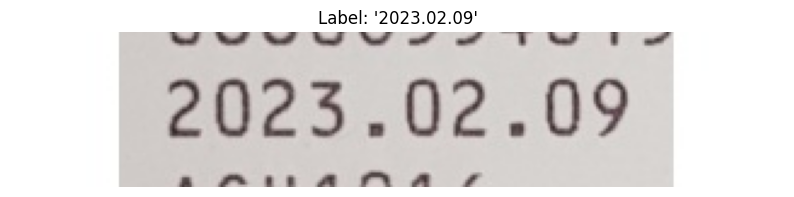

이미지 크기: (64, 320, 3)


In [39]:
# 실제 크롭된 이미지와 라벨 확인
import cv2
import matplotlib.pyplot as plt

# 실제 크롭된 이미지 크기
img = cv2.imread('/content/recdata/train/imgs/medicine_00002_0000.jpg')
print(f'Image shape: {img.shape}')

# 첫 번째 샘플 확인
with open('/content/recdata/train.mini.txt', 'r', encoding='utf-8') as f:
    first_line = f.readline().strip()
    img_path, label = first_line.split('\t')

print(f"이미지 경로: {img_path}")
print(f"라벨: '{label}'")

# 이미지 시각화
img = cv2.imread(img_path)
if img is not None:
    plt.figure(figsize=(10, 3))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Label: '{label}'")
    plt.axis('off')
    plt.show()
    print(f"이미지 크기: {img.shape}")
else:
    print("이미지를 읽을 수 없습니다!")

분석할 이미지 수: 2000
진행률: 0/2000
진행률: 200/2000
진행률: 400/2000
진행률: 600/2000
진행률: 800/2000
진행률: 1000/2000
진행률: 1200/2000
진행률: 1400/2000
진행률: 1600/2000
진행률: 1800/2000

=== 이미지 크기 통계 ===
총 분석된 이미지: 2000

너비 통계:
  평균: 320.0
  표준편차: 0.0
  최소: 320
  최대: 320
  중앙값: 320.0
  95%ile: 320.0

높이 통계:
  평균: 64.0
  표준편차: 0.0
  최소: 64
  최대: 64
  중앙값: 64.0
  95%ile: 64.0

=== 권장 고정 크기 ===
높이: 64 (95% 기준)
너비: 320 (95% 기준)
YAML 설정: image_shape: [3, 64, 320]


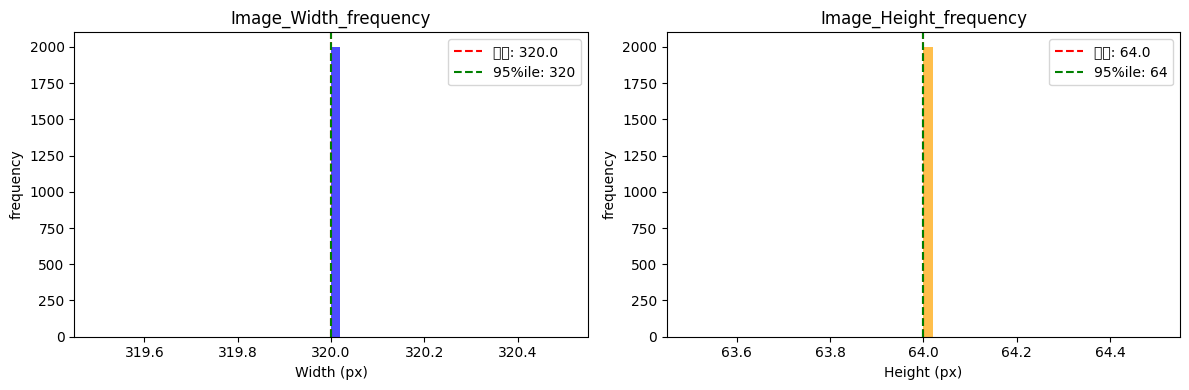

In [40]:
def analyze_image_sizes():
    """train.mini.txt의 모든 이미지 크기 분석"""

    widths = []
    heights = []

    with open('/content/recdata/train.mini.txt', 'r', encoding='utf-8') as f:
        lines = f.readlines()

    print(f"분석할 이미지 수: {len(lines)}")

    for i, line in enumerate(lines):
        if i % 200 == 0:
            print(f"진행률: {i}/{len(lines)}")

        img_path = line.strip().split('\t')[0]

        try:
            img = cv2.imread(img_path)
            if img is not None:
                h, w, _ = img.shape
                heights.append(h)
                widths.append(w)
        except Exception as e:
            print(f"에러 {img_path}: {e}")

    # 통계 계산
    widths = np.array(widths)
    heights = np.array(heights)

    print("\n=== 이미지 크기 통계 ===")
    print(f"총 분석된 이미지: {len(widths)}")
    print(f"\n너비 통계:")
    print(f"  평균: {widths.mean():.1f}")
    print(f"  표준편차: {widths.std():.1f}")
    print(f"  최소: {widths.min()}")
    print(f"  최대: {widths.max()}")
    print(f"  중앙값: {np.median(widths):.1f}")
    print(f"  95%ile: {np.percentile(widths, 95):.1f}")

    print(f"\n높이 통계:")
    print(f"  평균: {heights.mean():.1f}")
    print(f"  표준편차: {heights.std():.1f}")
    print(f"  최소: {heights.min()}")
    print(f"  최대: {heights.max()}")
    print(f"  중앙값: {np.median(heights):.1f}")
    print(f"  95%ile: {np.percentile(heights, 95):.1f}")

    # 권장 크기 계산
    recommended_width = int(np.percentile(widths, 95))
    recommended_height = int(np.percentile(heights, 95))

    print(f"\n=== 권장 고정 크기 ===")
    print(f"높이: {recommended_height} (95% 기준)")
    print(f"너비: {recommended_width} (95% 기준)")
    print(f"YAML 설정: image_shape: [3, {recommended_height}, {recommended_width}]")

    # 히스토그램 그리기
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=50, alpha=0.7, color='blue')
    plt.axvline(widths.mean(), color='red', linestyle='--', label=f'평균: {widths.mean():.1f}')
    plt.axvline(recommended_width, color='green', linestyle='--', label=f'95%ile: {recommended_width}')
    plt.xlabel('Width (px)')
    plt.ylabel('frequency')
    plt.title('Image_Width_frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=50, alpha=0.7, color='orange')
    plt.axvline(heights.mean(), color='red', linestyle='--', label=f'평균: {heights.mean():.1f}')
    plt.axvline(recommended_height, color='green', linestyle='--', label=f'95%ile: {recommended_height}')
    plt.xlabel('Height (px)')
    plt.ylabel('frequency')
    plt.title('Image_Height_frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return recommended_height, recommended_width

if __name__ == "__main__":
    h, w = analyze_image_sizes()

In [41]:
from pathlib import Path
import json
import cv2
import numpy as np
from tqdm import tqdm

# Data paths
IMG_ROOT = Path("/content/data/원천데이터/TS1")          # images:   TS1/{train,val}
ANN_ROOT = Path("/content/data/라벨링데이터/TL1")        # labels:   TL1/{train,val}
MANIFEST_DIR = Path("/content/manifests")                # split_{train,val}.csv (optional)
OUT_ROOT = Path("/content/recdata")

# Create output directories
(OUT_ROOT/"train/imgs").mkdir(parents=True, exist_ok=True)
(OUT_ROOT/"val/imgs").mkdir(parents=True, exist_ok=True)

# ---------------- I/O helpers ----------------
def safe_imread(p):
    p = str(p)
    data = np.fromfile(p, dtype=np.uint8)
    return cv2.imdecode(data, cv2.IMREAD_COLOR)

def safe_imsave(p, img):
    p = Path(p); p.parent.mkdir(parents=True, exist_ok=True)
    ok, buf = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
    if ok: buf.tofile(str(p))

def resize_for_ocr(img, target_height=64, target_width=320):
    """
    Resize image for OCR while maintaining aspect ratio and adding padding.
    Args:
        img: Input image (numpy array)
        target_height: Target height (default: 64)
        target_width: Target width (default: 320)
    Returns:
        Resized image with padding
    """
    if img is None or img.size == 0:
        return None

    h, w = img.shape[:2]

    # Calculate scale to fit within target dimensions
    scale = min(target_height / h, target_width / w)
    new_h, new_w = int(h * scale), int(w * scale)

    # Resize image
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create canvas with target size and fill with white background
    canvas = np.ones((target_height, target_width, 3), dtype=np.uint8) * 255

    # Center the resized image on canvas
    y_offset = (target_height - new_h) // 2
    x_offset = (target_width - new_w) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    return canvas

# ---------------- Geometry helpers ----------------
def clip_box(x1, y1, x2, y2, w, h):
    x1 = max(0, min(int(x1), w-1))
    y1 = max(0, min(int(y1), h-1))
    x2 = max(0, min(int(x2), w-1))
    y2 = max(0, min(int(y2), h-1))
    if x2 <= x1: x2 = min(w-1, x1+1)
    if y2 <= y1: y2 = min(h-1, y1+1)
    return x1, y1, x2, y2

def _aabb_from_points(pts):
    xs = [float(p[0]) for p in pts]; ys = [float(p[1]) for p in pts]
    return [min(xs), min(ys), max(xs), max(ys)]

def aabb_from_mixed(bbox):
    """
    bbox → [x1,y1,x2,y2] 변환.
    지원:
      - dict {x,y,width,height}
      - [x,y,w,h]
      - [[x,y], ...]  (polygon/quad)
      - [ {x,y,width,height}, ... ]  (여러 조각 → 합집합)
    """
    def _is_num(x):
        try:
            float(x); return True
        except Exception:
            return False

    def _xywh(x,y,w,h): return [float(x), float(y), float(x)+float(w), float(y)+float(h)]
    def _from_points(pts):
        xs = [float(p[0]) for p in pts]; ys = [float(p[1]) for p in pts]
        return [min(xs), min(ys), max(xs), max(ys)]
    def _union(boxes):
        xs1=[b[0] for b in boxes]; ys1=[b[1] for b in boxes]
        xs2=[b[2] for b in boxes]; ys2=[b[3] for b in boxes]
        return [min(xs1), min(ys1), max(xs2), max(ys2)]

    # dict
    if isinstance(bbox, dict):
        x=bbox.get("x", bbox.get("left")); y=bbox.get("y", bbox.get("top"))
        w=bbox.get("width", bbox.get("w")); h=bbox.get("height", bbox.get("h"))
        if all(_is_num(v) for v in [x,y,w,h]):
            return _xywh(x,y,w,h)

    # list
    if isinstance(bbox, list):
        # [x,y,w,h]
        if len(bbox)==4 and all(_is_num(v) for v in bbox):
            x,y,w,h = bbox; return _xywh(x,y,w,h)
        # [[x,y], ...]
        if len(bbox)>=2 and all(isinstance(p,(list,tuple)) and len(p)==2 for p in bbox):
            return _from_points(bbox)
        # [ {x,y,width,height}, ... ]  (조각 리스트 → 합집합)
        if len(bbox)>=1 and all(isinstance(it, dict) for it in bbox):
            boxes=[]
            for it in bbox:
                x=it.get("x"); y=it.get("y"); w=it.get("width"); h=it.get("height")
                if None not in (x,y,w,h):
                    boxes.append(_xywh(x,y,w,h))
            if boxes:
                return _union(boxes)

    return None

# ---------------- JSON parser (your schema) ----------------
def parse_gt(json_path: Path):
    """
    네 JSON 구조 전용 파서:
      annotations[*].bbox     : [{'id','x','y','width','height'}, ...]
      annotations[*].polygons : [{'id','points':[[x,y],...], 'text':"...", ...}, ...]
    - text는 polygon['text']
    - bbox는 polygon points로 AABB 계산(정밀), 실패 시 동일 id의 xywh 사용
    return: [{'text': str, 'bbox': [x1,y1,x2,y2]}, ...]
    """
    out = []
    try:
        data = json.loads(json_path.read_text(encoding="utf-8"))
    except Exception:
        return out

    anns = data.get("annotations", [])
    if not isinstance(anns, list) or not anns:
        return out

    for ann in anns:
        # id → xyxy bbox map (from xywh)
        bbox_by_id = {}
        for b in ann.get("bbox", []) or []:
            try:
                _id = b.get("id")
                x, y = float(b.get("x")), float(b.get("y"))
                w, h = float(b.get("width")), float(b.get("height"))
                bbox_by_id[_id] = [x, y, x + w, y + h]
            except Exception:
                continue

        # polygons: use points → AABB (preferred), else fall back to bbox_by_id
        for poly in ann.get("polygons", []) or []:
            _id  = poly.get("id")
            text = poly.get("text", "")
            text = "" if text is None else str(text).replace("\t"," ").replace("\n"," ").strip()

            # Skip if empty after cleaning
            if text == "":
                continue

            # Skip if too short (less than 2 characters)
            if len(text) < 2:
                continue

            # Skip if only special characters (no Korean or alphanumeric)
            import re
            if re.match(r'^[^\w가-힣]+$', text):
                continue

            aabb = None
            pts = poly.get("points")
            if isinstance(pts, list) and len(pts) >= 2 and all(isinstance(p,(list,tuple)) and len(p)==2 for p in pts):
                try:
                    aabb = _aabb_from_points(pts)
                except Exception:
                    aabb = None
            if aabb is None:
                aabb = bbox_by_id.get(_id)

            if aabb is not None:
                out.append({"text": text, "bbox": aabb})

    return out

# ---------------- Pairs & dataset builders ----------------
def build_pairs_from_manifest(split):
    pairs = []

    # Always use directory scan approach since manifest paths don't match actual file structure
    img_dir = IMG_ROOT / split
    ann_dir = ANN_ROOT / split

    if not (img_dir.exists() and ann_dir.exists()):
        print(f"[WARNING] Directory not found: {img_dir} or {ann_dir}")
        return pairs

    # Scan directory for image-annotation pairs (stem matching)
    for img_path in img_dir.glob("*.jpg"):
        stem = img_path.stem
        ann_candidates = list(ann_dir.glob(f"{stem}.json"))
        if ann_candidates:
            pairs.append((img_path, ann_candidates[0]))

    print(f"[INFO] Found {len(pairs)} image-annotation pairs in {split}")
    return pairs

def make_rec_split(split, pad_ratio=0.1, min_px=16):
    out_dir = OUT_ROOT/split/"imgs"
    list_path = OUT_ROOT/f"{split}.txt"
    pairs = build_pairs_from_manifest(split)

    n_total = 0
    with open(list_path, "w", encoding="utf-8") as fw:
        for img_path, ann_path in tqdm(pairs, desc=f"Make Rec {split}", unit="img"):
            img = safe_imread(img_path)
            if img is None:
                continue
            H, W = img.shape[:2]
            gts = parse_gt(ann_path)

            for k, it in enumerate(gts):
                x1, y1, x2, y2 = it["bbox"]
                # padding
                pad = int(pad_ratio * max(x2-x1, y2-y1))
                x1p, y1p, x2p, y2p = clip_box(x1-pad, y1-pad, x2+pad, y2+pad, W, H)
                crop = img[y1p:y2p, x1p:x2p]
                if crop.size == 0:
                    continue
                # too small → skip
                if (y2p - y1p) < min_px or (x2p - x1p) < min_px:
                    continue

                crop_resized = resize_for_ocr(crop, target_height=64, target_width=320)
                if crop_resized is None:
                    continue

                out_name = f"{img_path.stem}_{k:04d}.jpg"
                out_path = out_dir / out_name
                safe_imsave(out_path, crop_resized)

                # PaddleOCR Rec format: <abs_path>\t<label>
                fw.write(f"{str(out_path)}\t{it['text']}\n")
                n_total += 1

    return n_total, list_path

# ---------------- Run (train / val) ----------------
train_cnt, train_txt = make_rec_split("train", pad_ratio=0.1, min_px=16)
val_cnt,   val_txt   = make_rec_split("val",   pad_ratio=0.1, min_px=16)
print(f"[DONE] train crops: {train_cnt} → {train_txt}")
print(f"[DONE] val crops:   {val_cnt} → {val_txt}")

[INFO] Found 304 image-annotation pairs in train


Make Rec train: 100%|██████████| 304/304 [00:33<00:00,  9.00img/s]


[INFO] Found 38 image-annotation pairs in val


Make Rec val: 100%|██████████| 38/38 [00:04<00:00,  8.38img/s]

[DONE] train crops: 10462 → /content/recdata/train.txt
[DONE] val crops:   919 → /content/recdata/val.txt


#### 학습 실행

In [42]:
!head -50 /content/paddleocr.yaml


Global:
  debug: false
  use_gpu: true
  epoch_num: 30
  log_smooth_window: 20
  print_batch_step: 10
  save_model_dir: ./output/rec_crnn
  save_epoch_step: 3
  eval_batch_step: [0, 2000]
  cal_metric_during_train: true
  pretrained_model:
  checkpoints:
  save_inference_dir:
  use_visualdl: false
  infer_img: doc/imgs_words/ch/word_1.jpg
  character_dict_path: /content/recdata/charset.txt
  max_text_length: 50
  infer_mode: false
  use_space_char: true
  distributed: false
  save_res_path: ./output/rec/predicts_crnn.txt

Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    name: Cosine
    learning_rate: 0.0002
    warmup_epoch: 5
  regularizer:
    name: L2
    factor: 2.0e-05

Architecture:
  model_type: rec
  algorithm: CRNN
  Transform:
  Backbone:
    name: MobileNetV3
    scale: 0.5
    model_name: small
    small_stride: [1, 2, 2, 2]
  Neck:
    name: SequenceEncoder
    encoder_type: rnn
    hidden_size: 64
  Head:
    name: CTCHead


In [ ]:
# 학습 시작
%cd /content/PaddleOCR
!python tools/train.py -c /content/paddleocr.yaml

/content/PaddleOCR
[2025/08/13 20:19:41] ppocr WARNING: Skipping import of the encryption module.
[2025/08/13 20:19:41] ppocr INFO: Architecture : 
[2025/08/13 20:19:41] ppocr INFO:     Backbone : 
[2025/08/13 20:19:41] ppocr INFO:         model_name : small
[2025/08/13 20:19:41] ppocr INFO:         name : MobileNetV3
[2025/08/13 20:19:41] ppocr INFO:         scale : 0.5
[2025/08/13 20:19:41] ppocr INFO:         small_stride : [1, 2, 2, 2]
[2025/08/13 20:19:41] ppocr INFO:     Head : 
[2025/08/13 20:19:41] ppocr INFO:         fc_decay : 1e-05
[2025/08/13 20:19:41] ppocr INFO:         name : CTCHead
[2025/08/13 20:19:41] ppocr INFO:         out_char_num : 192
[2025/08/13 20:19:41] ppocr INFO:     Neck : 
[2025/08/13 20:19:41] ppocr INFO:         encoder_type : rnn
[2025/08/13 20:19:41] ppocr INFO:         hidden_size : 64
[2025/08/13 20:19:41] ppocr INFO:         name : SequenceEncoder
[2025/08/13 20:19:41] ppocr INFO:     Transform : None
[2025/08/13 20:19:41] ppocr INFO:     algorithm

#### CER/WER 미학습

In [43]:
# PaddlePaddle GPU 버전 (CUDA 11.7 기준)
!pip install paddlepaddle-gpu==2.6.1.post117 \
    -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html

# PaddleOCR 설치 (소스 구조 포함)
!pip install paddleocr==2.7.0.3

Looking in links: https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.6/758.6 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: paddlepaddle-gpu
    Found existing installation: paddlepaddle-gpu 2.6.1
    Uninstalling paddlepaddle-gpu-2.6.1:
      Successfully uninstalled paddlepaddle-gpu-2.6.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.6/351.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [ ]:
%cd PaddleOCR
!pip install -r requirements.txt

In [ ]:
import os, sys, re, json, math, time, random
import yaml

# add PaddleOCR repo to path
REPO_DIR = "/content/PaddleOCR"
if REPO_DIR not in sys.path:
    sys.path.insert(0, REPO_DIR)

import paddle
from ppocr.modeling.architectures import build_model
from ppocr.postprocess import build_post_process
from ppocr.data.imaug import create_operators

# ---------------------- Config ----------------------
YAML_PATH      = Path("/content/paddleocr.yaml")
VAL_LIST_PATH  = Path("/content/recdata/val.mini.txt")
DEVICE_GPU     = paddle.device.is_compiled_with_cuda() and paddle.device.get_device().startswith("gpu")
BATCH_SIZE     = 8

assert YAML_PATH.exists(), f"YAML not found: {YAML_PATH}"
assert VAL_LIST_PATH.exists(), f"List file not found: {VAL_LIST_PATH}"

# ---------------------- Utils ----------------------
def safe_imread(p):
    data = np.fromfile(str(p), dtype=np.uint8)
    if data.size == 0: return None
    img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return img

def clean_text(text: str):
    if not text: return ""
    return re.sub(r"\s+", " ", text).strip()

def cer(pred, gt):
    pred = pred or ""
    gt   = gt or ""
    if len(gt) == 0:
        return 1.0 if len(pred) > 0 else 0.0
    dp = [[0]*(len(gt)+1) for _ in range(len(pred)+1)]
    for i in range(len(pred)+1): dp[i][0] = i
    for j in range(len(gt)+1):   dp[0][j] = j
    for i in range(1, len(pred)+1):
        for j in range(1, len(gt)+1):
            cost = 0 if pred[i-1] == gt[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1, dp[i][j-1] + 1, dp[i-1][j-1] + cost)
    return dp[len(pred)][len(gt)] / len(gt)

def wer(pred, gt):
    pw = (pred or "").split()
    gw = (gt or "").split()
    if len(gw) == 0:
        return 1.0 if len(pw) > 0 else 0.0
    dp = [[0]*(len(gw)+1) for _ in range(len(pw)+1)]
    for i in range(len(pw)+1): dp[i][0] = i
    for j in range(len(gw)+1): dp[0][j] = j
    for i in range(1, len(pw)+1):
        for j in range(1, len(gw)+1):
            cost = 0 if pw[i-1] == gw[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1, dp[i][j-1] + 1, dp[i-1][j-1] + cost)
    return dp[len(pw)][len(gw)]

def load_list(path: Path):
    pairs=[]
    for ln in path.read_text(encoding="utf-8").splitlines():
        if "\t" not in ln: continue
        img, gt = ln.split("\t", 1)
        pairs.append((img, gt))
    return pairs

# ---------------------- Build model (NO PRETRAINED) ----------------------
# Load YAML
cfg_txt = YAML_PATH.read_text(encoding="utf-8")
cfg     = yaml.safe_load(cfg_txt)

# Ensure NO pretrained
if "Global" not in cfg: cfg["Global"] = {}
# Remove potential pretrained entries
for key in ["pretrained_model", "checkpoints"]:
    if key in cfg["Global"]:
        cfg["Global"].pop(key, None)

# Build model (random init)
model = build_model(cfg["Architecture"])
model.eval()

# Device
paddle.set_device("gpu" if DEVICE_GPU else "cpu")
print(f"[INFO] Device: {'GPU' if DEVICE_GPU else 'CPU'}")

# Build post-process (CTCLabelDecode) from YAML
post_cfg = cfg.get("PostProcess", {})
post_process = build_post_process(post_cfg)

# Build transforms (use Train transforms for resize/normalize)
# (Train/Eval 동일하게 맞춰져 있다면 어느 쪽을 써도 무관)
ops_cfg = cfg["Train"]["dataset"]["transforms"]
ops = create_operators(ops_cfg)

def preprocess_single(img_path):
    img = safe_imread(img_path)
    if img is None:
        raise ValueError(f"cannot read image: {img_path}")
    data = {"image": img}
    for op in ops:
        data = op(data)
        if data is None:         # e.g., filtered by operators
            raise ValueError(f"transform returned None for {img_path}")
    # Expect keys: "image" (C,H,W), "label", "length" (label/length는 학습용이지만 image만 필요)
    im = data["image"]
    if isinstance(im, np.ndarray):
        im = paddle.to_tensor(im)
    if len(im.shape) == 3:
        im = im.unsqueeze(0)     # (1,C,H,W)
    return im

# ---------------------- Evaluate ----------------------
pairs = load_list(VAL_LIST_PATH)
print(f"[INFO] Evaluating {len(pairs)} samples with UNTRAINED(random) model")

tot_cer=0.0; tot_wer=0.0; n=0
samples_to_show = 5

with paddle.no_grad():
    for (img_path, gt_text) in pairs:
        try:
            inp = preprocess_single(img_path)  # (1,C,H,W), float32
            # Forward
            out = model(inp)                   # dict with "head_out" (CTC logits)
            logits = out["head_out"] if isinstance(out, dict) else out

            # Post-process (CTC greedy decode)
            decoded = post_process(logits)     # list of dict: [{'text': '...', 'score': ...}, ...]
            pred_text = decoded[0]["text"] if decoded and len(decoded)>0 else ""

            pred_text = clean_text(pred_text)
            gt_text   = clean_text(gt_text)

            c = cer(pred_text, gt_text)
            w = wer(pred_text, gt_text)
            tot_cer += c; tot_wer += w; n += 1

            if n <= samples_to_show:
                print(f"\n[Sample {n}]")
                print(f"GT  : {gt_text}")
                print(f"PRED: {pred_text}")
                print(f"CER : {c:.3f}  WER: {w:.3f}")

        except Exception as e:
            print(f"[WARN] skip due to error: {img_path} -> {e}")

if n>0:
    avg_cer = tot_cer / n
    avg_wer = tot_wer / n
    print("\n" + "="*56)
    print("[RESULTS] UNTRAINED (random init) PaddleOCR REC")
    print(f"Samples: {n}")
    print(f"Average CER: {avg_cer:.4f}  ({avg_cer*100:.1f}%)")
    print(f"Average WER: {avg_wer:.4f}  ({avg_wer*100:.1f}%)")
    print("="*56 + "\n")
else:
    print("[ERROR] No valid samples evaluated.")